In [1]:
# Standard libraries
from copy import deepcopy

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu, wilcoxon, binom_test, combine_pvalues

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.plotting import imshow, stat_annot_patches
from mesostat.utils.pandas_helper import get_rows_colvals

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
from src.lib.metric_wrapper import metric_by_selector_all, metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
import src.lib.tests_phase_signle_cell as single_cell_tests
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-neuro/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
# params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
# params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Neuron-Time-Average

**Goal**: Attempt to predict phase from mean activity over trial

# 2 Time-Average

**Goal**: Attempt to predict phase from average activities of individual cells.
* Count predictive cells in each mouse
* Test overlap over phases/intervals - identify how many significant cells overlap

## 2.1 avg-firing-rate by neuron
 -> heatmap by mouse | 1D plot by neurons

In [ ]:
def plot_avg_firing_rate_by_neuron(datatype, phaseType, haveWaiting=True):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    for mousename in sorted(dataDB.mice):
        fig, ax = plt.subplots(ncols=4, figsize=(4*2, 6), tight_layout=True)
        fig.suptitle(mousename)
        iCol = 0

        for performance in dataDB.get_performances():
            if phaseType != 'phase':
                boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting)

            for direction in dataDB.get_directions():
                queryDict = {'datatype' : datatype, 'mousename' : mousename, 'performance' : performance, 'direction' : direction}
                means = metric_by_selector_all(dataDB, queryDict, phaseType, 'mean', 'p', settings, haveWaiting=haveWaiting)                
                means = means.T
                
                print(means.shape)

                # Sort by max argument
                # But only based on the first one (CL) so that all 4 combinations have the same sorting
                if iCol == 0:
                    idxsMaxArgs = np.argsort(np.array([np.argmax(m) for m in means]))
                means = means[idxsMaxArgs]

                title = direction[0] + performance[0]
                imshow(fig, ax[iCol], means, limits=None, title=title, haveColorBar=True)
                if phaseType != 'phase':
                    for bline in boundingLines:
                        ax[iCol].axvline(x=bline-1, linestyle='--', color='r', alpha=0.5)

                iCol += 1

        plt.savefig(mousename + '_avgrate_' + phaseType + '.pdf')
        plt.close()

### 2.1.1 avg-firing-rate by neuron and interval

In [ ]:
plot_avg_firing_rate_by_neuron('zscore', 'interval', haveWaiting=False)

### 2.1.2 avg-firing-rate by neuron and phase

In [ ]:
plot_avg_firing_rate_by_neuron('zscore', 'phase', haveWaiting=False)

In [ ]:
plot_avg_firing_rate_by_neuron('zscore', 'semiphase', haveWaiting=False)

## 2.2 significant-avg-firing-rate by neuron

In [13]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def gen_cmap_2color(c1, c2):
    vals = np.ones((256, 4))
    vals[:, 0] = np.linspace(c1[0], c2[0], 256) / 255
    vals[:, 1] = np.linspace(c1[1], c2[1], 256) / 255
    vals[:, 2] = np.linspace(c1[2], c2[2], 256) / 255    
    return ListedColormap(vals)

def gen_cmap_3color(c1, c2, c3):
    r1 = np.linspace(c1[0], c2[0], 128) / 255
    g1 = np.linspace(c1[1], c2[1], 128) / 255
    b1 = np.linspace(c1[2], c2[2], 128) / 255    
    r2 = np.linspace(c2[0], c3[0], 128) / 255
    g2 = np.linspace(c2[1], c3[1], 128) / 255
    b2 = np.linspace(c2[2], c3[2], 128) / 255
    
    vals = np.ones((256, 4))
    vals[:, 0] = np.hstack([r1, r2])
    vals[:, 1] = np.hstack([g1, g2])
    vals[:, 2] = np.hstack([b1, b2])
    return ListedColormap(vals)

# cmapConfusion = gen_cmap_3color(
#     np.array([255, 255, 255]),
#     np.array([168, 217, 49]),
#     np.array([255, 0, 0])
# )

cmapConfusion = gen_cmap_3color(
    np.array([0,0,0]),
    np.array([255,198,126]),
    np.array([233,79,25])
)

cmapSignificance = gen_cmap_2color(
    np.array([255, 255, 255]),
    np.array([233, 79, 25])
)

In [25]:
def plot_significant_firing_rate_by_neuron(datatype, phaseType, confThr=0.01, haveWaiting=True):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    performanceValues = dataDB.get_performances()
    directionValues = dataDB.get_directions()
    
    if phaseType == 'phase':
        performanceValues += ['All']
        directionValues += ['All']
        
    nCol = len(performanceValues) * len(directionValues)
    cumulConfDict = {}
    
    for mousename in sorted(dataDB.mice):
        print('doing mouse', mousename)
        nChannel = dataDB.get_nchannel(mousename, datatype)

        fig1, ax1 = plt.subplots(ncols=nCol, figsize=(nCol*2, 6), tight_layout=True)
        fig2, ax2 = plt.subplots(ncols=nCol, figsize=(nCol*4, 4), tight_layout=True)

        fig1.suptitle(mousename)
        fig2.suptitle(mousename)
        iCol = 0

        for performance in performanceValues:
            if phaseType != 'phase':
                boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting)
                    
            for direction in directionValues:
                queryDict = {'datatype' : datatype, 'mousename' : mousename}
                if performance != 'All':
                    queryDict = {**queryDict, **{'performance' : performance}}
                if direction != 'All':
                    queryDict = {**queryDict, **{'direction' : direction}}
                    
                # Calculate p-values
                pVals2D = single_cell_tests.test_inverse_all_selectors(dataDB, queryDict, phaseType, metricName='mean', alternative="greater", haveWaiting=haveWaiting, settings=settings)
                negLogPVals2D = -np.log10(pVals2D)
                
                # Calculate significant cells and confusion matrix
                signCellsByPhase = single_cell_tests.pvalues_2_significant_cells(pVals2D, confThr)
                confMat = single_cell_tests.significance_confusion_matrix(signCellsByPhase) / nChannel

                # Sort by max argument
                # But only based on the first one (CL) so that all 4 combinations have the same sorting
                if iCol == 0:
                    idxsMaxArgs = np.argsort(np.array([np.argmax(p) for p in negLogPVals2D]))
                negLogPVals2D = negLogPVals2D[idxsMaxArgs]

                colorBoundingLines = 'white'
                cmapSignificant = 'copper' #'YlOrBr' # 'viridis'
                title = direction[0] + performance[0]
                if phaseType != 'phase':
                    imshow(fig1, ax1[iCol], negLogPVals2D, limits=[0, 4], title=title, haveColorBar=True, cmap=cmapSignificant)
                    for bline in boundingLines:
                        ax1[iCol].axvline(x=bline-1, linestyle='--', color=colorBoundingLines, alpha=1)
                else:
                    imshow(fig1, ax1[iCol], negLogPVals2D, limits=[0, 4], title=title, haveTicks=True, haveColorBar=False, cmap=cmapSignificant)
                    
                ax1[iCol].set_yticks(np.arange(0, len(negLogPVals2D), 10))

                # Plot confusion matrix
                imshow(fig2, ax2[iCol], confMat, limits=[0, 1], title=title, haveColorBar=True, cmap=cmapConfusion)
                if phaseType != 'phase':
                    for bline in boundingLines:
                        ax2[iCol].axvline(x=bline-1, linestyle='--', color=colorBoundingLines, alpha=1)
                        ax2[iCol].axhline(y=bline-1, linestyle='--', color=colorBoundingLines, alpha=1)
                
                # Store confusion matrices 
                cumulConfDict[(mousename, direction, performance)] = confMat
                
                iCol += 1

        fig1.savefig(mousename + '_significantrate_' + datatype + '_' + phaseType + '.png')
        plt.close()
        fig2.savefig(mousename + '_significantrate_' + datatype + '_' + phaseType + '_confusion.pdf')
        plt.close()

    iCol = 0
    figAll, axAll = plt.subplots(ncols=nCol, figsize=(nCol*4, 4), tight_layout=True)    
    for performance in performanceValues:
        for direction in directionValues:
            confThisCondition = [cumulConfDict[(mousename, direction, performance)] for mousename in dataDB.mice]
            confAvg = np.mean(confThisCondition, axis=0)
            
            title = direction[0] + performance[0]
            imshow(figAll, axAll[iCol], confAvg, limits=[0, 1], title=title, haveColorBar=True, cmap=cmapConfusion)
            if phaseType != 'phase':
                boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting)
                
                for bline in boundingLines:
                    axAll[iCol].axvline(x=bline-1, linestyle='--', color=colorBoundingLines, alpha=1)
                    axAll[iCol].axhline(y=bline-1, linestyle='--', color=colorBoundingLines, alpha=1)
            
            iCol += 1
            
    figAll.savefig('Allmice_significantrate_' + phaseType + '_confusion.pdf')
    plt.close()

deconv semiphase
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517

KeyboardInterrupt: 

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


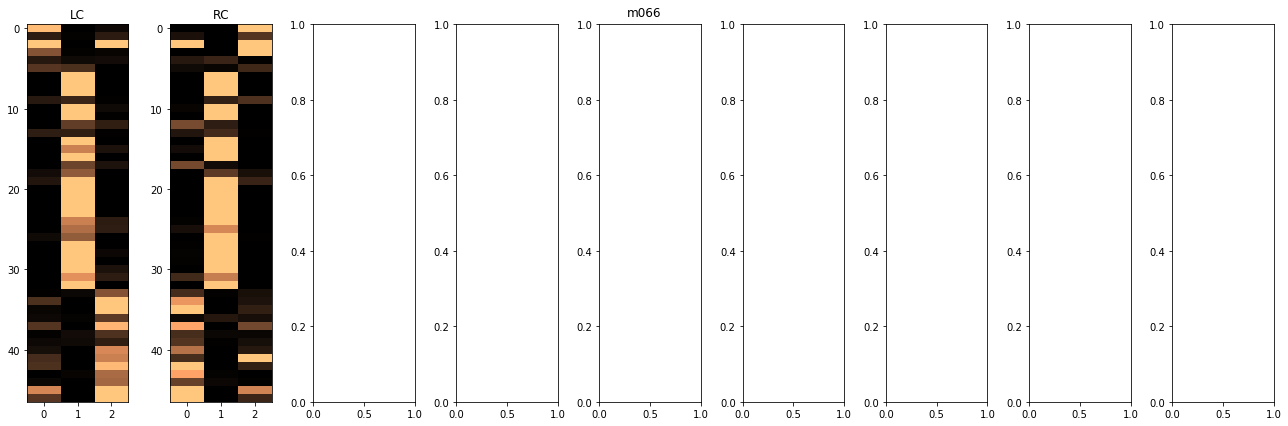

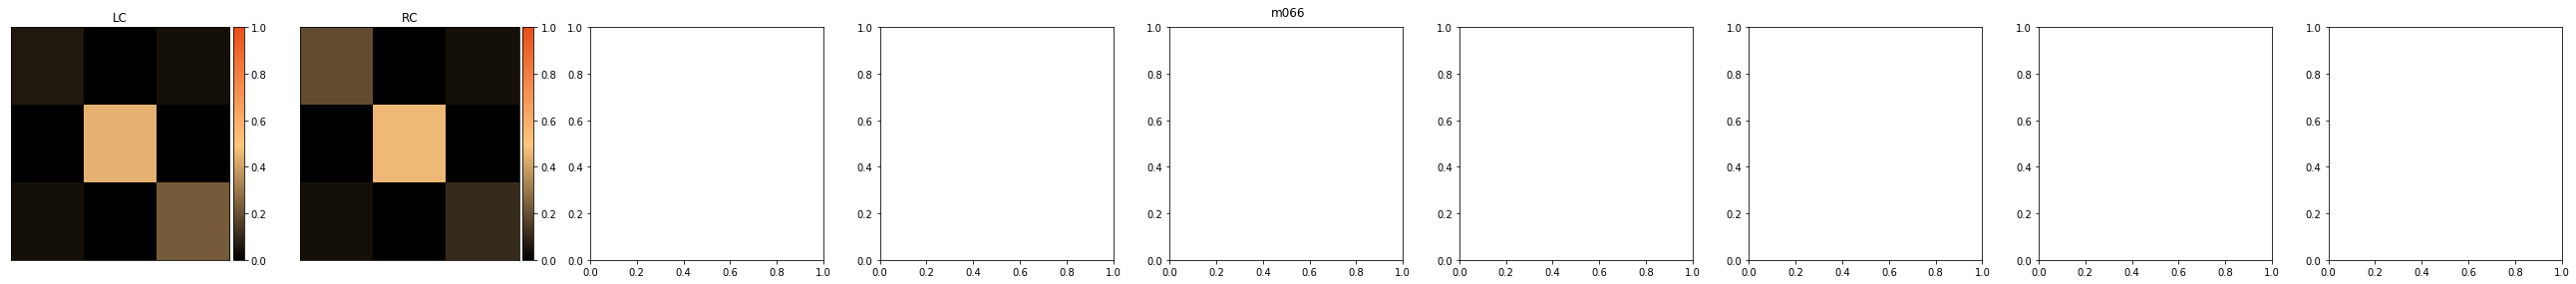

In [26]:
for datatype in ['deconv', 'raw']:
    for phasetype in ['semiphase', 'phase', 'interval']:
        print(datatype, phasetype)
        plot_significant_firing_rate_by_neuron(datatype, phasetype, confThr=0.01, haveWaiting=False)

## 2.3 Storing significant neurons, counting across mice

In [17]:
def plot_df_count_by_mice(ax, data1, data2, label1, label2, xLabels, nCellPerMouse):
    dataNorm1 = np.array(data1) / np.array(nCellPerMouse)
    dataNorm2 = np.array(data2) / np.array(nCellPerMouse)
    pVals = [binom_test(d1, d1 + d2) for d1, d2 in zip(data1, data2)]
    
    xInd = np.arange(len(xLabels))
    width = 0.35  # the width of the bars
    
    rects1 = ax.bar(xInd - width/2, dataNorm1, width, label=label1)
    rects2 = ax.bar(xInd + width/2, dataNorm2, width, label=label2)
    
    for patch1, patch2, pVal in zip(rects1.patches, rects2.patches, pVals):
        stat_annot_patches(ax, patch1, patch2, pVal, fontsize=20)
    
    ax.set_xticks(xInd)
    ax.set_xticklabels(xLabels)
    
def plot_df_count_combined(ax, data1, data2, label1, label2, nCellPerMouse):
    # Convert from counts to fractions
    dataNorm1 = np.array(data1) / np.array(nCellPerMouse)
    dataNorm2 = np.array(data2) / np.array(nCellPerMouse)
    dataMean1 = np.mean(dataNorm1)
    dataMean2 = np.mean(dataNorm2)
    
    # Compute p-values and combine
    pVals = [binom_test(d1, d1 + d2) for d1, d2 in zip(data1, data2)]
    pValMean = combine_pvalues(pVals)[1]
    
    # Plot Bars
    width = 0.30  # the width of the bars
    dist = 0.05
    rects1 = ax.bar([-(width + dist)/2], [dataMean1], width, label=label1)
    rects2 = ax.bar([+(width + dist)/2], [dataMean2], width, label=label2)
        
    # Plot individual lines
    for d1, d2 in zip(dataNorm1, dataNorm2):
        ax.plot([-(width + dist)/2, (width + dist)/2], [d1, d2], color='gray')
        
    # Annotate bars
    for patch1, patch2 in zip(rects1.patches, rects2.patches):
        stat_annot_patches(ax, patch1, patch2, pValMean, fontsize=20)
        
    ax.set_xticks([])
    ax.set_ylim([0, 1.1*np.max(np.hstack([dataNorm1, dataNorm2]))])


def plot_save_significantly_firing_neurons(datatype, phaseType, exclusiveIndices, exclusiveLabels, ranges=None, confThr=0.01, haveAll=False):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}
    
    exclusiveLabelsKey = '_'.join(exclusiveLabels)

    significantCellsDict = {label : [] for label in exclusiveLabels}
    
    if not haveAll:
        performanceValues = ['Correct', 'Mistake']
        directionValues = ['L', 'R']
    else:
        performanceValues = ['Correct', 'Mistake', 'All']
        directionValues = ['L', 'R', 'All']
    
    mice = list(sorted(dataDB.mice))
    for mousename in mice:
        print('doing mouse', mousename)

        for performance in performanceValues:
            for direction in directionValues:
                queryDict = {'datatype' : datatype, 'mousename' : mousename}
                if performance != 'All':
                    queryDict = {**queryDict, **{'performance' : performance}}
                if direction != 'All':
                    queryDict = {**queryDict, **{'direction' : direction}}
                    
                # Calculate p-values and significant cells
                pVals2D = single_cell_tests.test_inverse_all_selectors(dataDB, queryDict, phaseType, metricName='mean', alternative="greater", settings=settings, ranges=ranges)
                signCellsByPhase = single_cell_tests.pvalues_2_significant_cells(pVals2D, confThr)

                # Determine maintenance-significant cells for storage
                exclusiveSets = single_cell_tests.find_exclusive_sets(signCellsByPhase, exclusiveIndices)

                for thisSet, thisLabel in zip(exclusiveSets, exclusiveLabels):
                    significantCellsDict[thisLabel] += [[mousename, performance, direction, np.array(list(thisSet))]]

    # Store significant cells in HDF5
    significantCellsDFDict = {}
    for label, signCellsData in significantCellsDict.items():
        dfCells = pd.DataFrame(signCellsData, columns=['mousename', 'performance', 'direction', 'cells'])
        dfCells.to_hdf('significant_cells_' + datatype + '_' + label + '.h5', key='df', mode='w')
        significantCellsDFDict[label] = dfCells
        
    nCellPerMouse = np.array([dataDB.get_nchannel(mousename, datatype) for mousename in mice])

    # Plot selector-specific number of significant cells vs mice
    for performance in performanceValues:
        for direction in directionValues:
            queryDict = {"performance" : performance, "direction" : direction}
            
            nSignCellByMouse = []
            for label, signCellsDF in significantCellsDFDict.items():
                rows = get_rows_colvals(signCellsDF, queryDict, dropQuery=True)
                nSignCellByMouse += [[len(list(row.values)[1]) for idx, row in rows.iterrows()]]
            
            ######################
            #  Plot by mouse
            ######################
            
            figCount, axCount = plt.subplots(figsize=(5, 5))
            plot_df_count_by_mice(axCount, *nSignCellByMouse, *exclusiveLabels, mice, nCellPerMouse)
                
            figKey = '_'.join([exclusiveLabelsKey, datatype, phaseType, performance, direction])
                
            axCount.legend()
            figCount.savefig('significantrate_by_mouse_' + figKey + '.pdf')
            plt.close()
            
            ######################
            #  Plot combined
            ######################
            
            figCountAll, axCountAll = plt.subplots(figsize=(5, 5))
            plot_df_count_combined(axCountAll, *nSignCellByMouse, *exclusiveLabels, nCellPerMouse)
            
            figCountAll.savefig('significantrate_combined_' + figKey + '.pdf')
            plt.close()

In [22]:
# Testing each phase vs remainder of the trial, storing maintenance vs encoding+retrieval
# for datatype in ['raw', 'deconv']:
#     plot_save_significantly_firing_neurons(datatype,
#                                            'phase',
#                                            [[1], [0, 2]],
#                                            ['mt', 'enc_ret'],
#                                            confThr=0.01,
#                                            haveAll=True)
    
    
for datatype in ['raw', 'deconv']:
    plot_save_significantly_firing_neurons(datatype,
                                           'phase',
                                           [[0], [2]],
                                           ['end', 'ret'],
                                           confThr=0.01,
                                           haveAll=True)

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No 

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['mousename', 'performance', 'direction', 'cells']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No 

In [ ]:
for datatype in ['raw', 'deconv']:
    plot_save_significantly_firing_neurons(datatype,
                                           'interval', 
                                           [[0], [1]],
                                           ['enc_base', 'enc_reward'],
                                           confThr=0.01,
                                           ranges=[2, 4],
                                           haveAll=True)

## 2.4 Load and test significant cells

In [ ]:
significantCellsSelectorDatatype = {}

for datatype in ['raw', 'deconv']:
    signCellsMaintenance = SignificantCells('significant_cells_'+datatype+'_mt.h5').get_cells_by_mouse()
    signCellsReward = SignificantCells('significant_cells_'+datatype+'_enc_reward.h5').get_cells_by_mouse()

    significantCellsSelectorDatatype[datatype] = {
        'None' : None,
        'Maintenance' : signCellsMaintenance,
        'Reward' : signCellsReward
    }

# 3.1 Table - Discriminate Phases by Metric

In [ ]:
%%time
dataDB.verbose = False

phases = ['Encoding', 'Maintenance', 'Retrieval']
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" :{"max_lag" : 1}}
sweepDict = {
    #"mousename" : sorted(list(dataDB.mice)),
    "datatype": ["deconv"],#, "raw", "high", "deconv"],
    "performance": ["Correct", "Mistake", "All"],
    "direction": ["L", "R", "All"]
}

table_lib.table_discriminate_time(dataDB, sweepDict,
                                         {"phase" : phases},
                                         "mean",
                                         trgDimOrder="r",
                                         settings=settings, multiplexKey="mousename")

# 3.2 Violins - Metric by Phase and Interval

In [ ]:
def plot_violins(datatype, phaseType, metricName, settings, haveWaiting=True, signCellsSelector=None):
    if signCellsSelector == None:
        signCellsSelector = {'None' : None}
        
    signCellsKey, signCellsMouseDict = list(signCellsSelector.items())[0]
    
    
    for performance in ["Correct", "Mistake"]:
        fig, ax = plt.subplots(ncols=3, figsize=(15,5))
        fig.suptitle(performance)

        intervalOrigIndices = dataDB.get_phasetype_keys(phaseType, performance)
        boundingLines = dataDB.get_phase_bounding_lines(phaseType, performance, haveWaiting=haveWaiting) - 1
        phases = dataDB.get_phasetype_keys('phase', performance, haveWaiting=haveWaiting)

        for mousename in sorted(dataDB.mice)[:-1]:
            queryThis = {"datatype" : datatype, "mousename" : mousename, "performance" : performance}  # "direction" : "R"
            rez2D = metric_by_selector_all(dataDB, queryThis, phaseType, metricName, 'p', settings, haveWaiting=haveWaiting, channelFilter=signCellsMouseDict)
    #         rez2D = rez2D[..., 0]
            plots_lib.plot_labeled_bars(ax[0], rez2D, intervalOrigIndices, plotLabel=mousename, alpha=0.2, vlines=boundingLines)

        rez2DIntervAll = metric_by_selector_all(dataDB, queryThis, phaseType, metricName, 'p', settings, haveWaiting=haveWaiting, channelFilter=signCellsMouseDict)
        rez2DPhaseAll = metric_by_selector_all(dataDB, queryThis, 'phase', metricName, 'p', settings, haveWaiting=haveWaiting, channelFilter=signCellsMouseDict)
        plots_lib.plot_labeled_bars(ax[1], rez2DIntervAll, intervalOrigIndices, vlines=boundingLines)        
        plots_lib.plot_labeled_violins(ax[2], rez2DPhaseAll, phases, "phase", metricName, joinMeans=True, printLogP=True)

        ax[0].legend()
        plt.savefig(phaseType+'_'+datatype+'_'+signCellsKey+'_avg_violins_'+performance+'.pdf')
        plt.show()

In [ ]:
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

        
for datatype in ['raw', 'deconv']:
    for phaseType in ['interval', 'semiphase']:
        for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
            print("datatype", datatype, "Significant Cells :", signCellsName)
            plot_violins(datatype, phaseType, "mean", settings, haveWaiting=False, signCellsSelector={signCellsName:signCells})